# Probabilistic forecasting I: Temperature — EDA which makes sense

This notebook shows an EDA for the time series data and a first, simple, model for probabilistic forecasting.

Reference: [Probabilistic forecasting I: Temperature](https://www.kaggle.com/competitions/probabilistic-forecasting-i-temperature)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal
import math
from colorama import Fore, Style

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reading the data

The training data has 64320 rows, corresponding to 670 days with 24\*4 rows per day. The test data has 5360 rows corresponding to almost 56 days (the final day ends at 7:45 pm).

In [3]:
train = pd.read_csv('../train.csv',
                    index_col='id', parse_dates=['date'])
test = pd.read_csv('../test.csv',
                   index_col='id', parse_dates=['date'])
exogenous_features = list(test.columns[1:]) # without date column

if not train.isna().any().any():
    print('There are no missing values in train.')
if not test.isna().any().any():
    print('There are no missing values in test.')
    
print(f"Train shape: {train.shape}   test shape: {test.shape}")

train

There are no missing values in train.
There are no missing values in test.
Train shape: (64320, 8)   test shape: (5360, 7)


,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
id,,,,,,,,
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
...,...,...,...,...,...,...,...,...
64315,2018-05-01 22:45:00,12.458,1.407,7.889,-0.746,4.843,1.523,10.622000
64316,2018-05-01 23:00:00,14.200,1.541,9.310,0.284,4.752,1.249,10.482000
64317,2018-05-01 23:15:00,12.659,1.474,7.924,-0.959,4.569,1.310,10.271000


Let's just confirm that every quarter of an hour is covered by the datasets:

In [4]:
if ((train.date - train.date.shift(1)).iloc[1:] == pd.to_timedelta(15, unit='m')).all():
    print('Train has a sample every 15 minutes.')
if ((test.date - test.date.shift(1)).iloc[1:] == pd.to_timedelta(15, unit='m')).all():
    print('Test has a sample every 15 minutes.')
    

Train has a sample every 15 minutes.
Test has a sample every 15 minutes.


# A first look at the data

As we are working with a time series dataset, we of course start by plotting all features and the target against time.

The diagram of the seven time series shows:
1. feature_AA and feature_BA have low variance in 2016 and higher variance later.
1. feature_AA and feature_BA look correlated.
1. feature_AB and feature_BB look correlated.
1. feature_CB has some outlier periods.
1. **Temperature is higher in summer than in winter (seasonality).**
1. **The temperature has a downward trend.**
1. And it looks like during the first year the temperature is noisier than during the second year (heteroscedasticity).

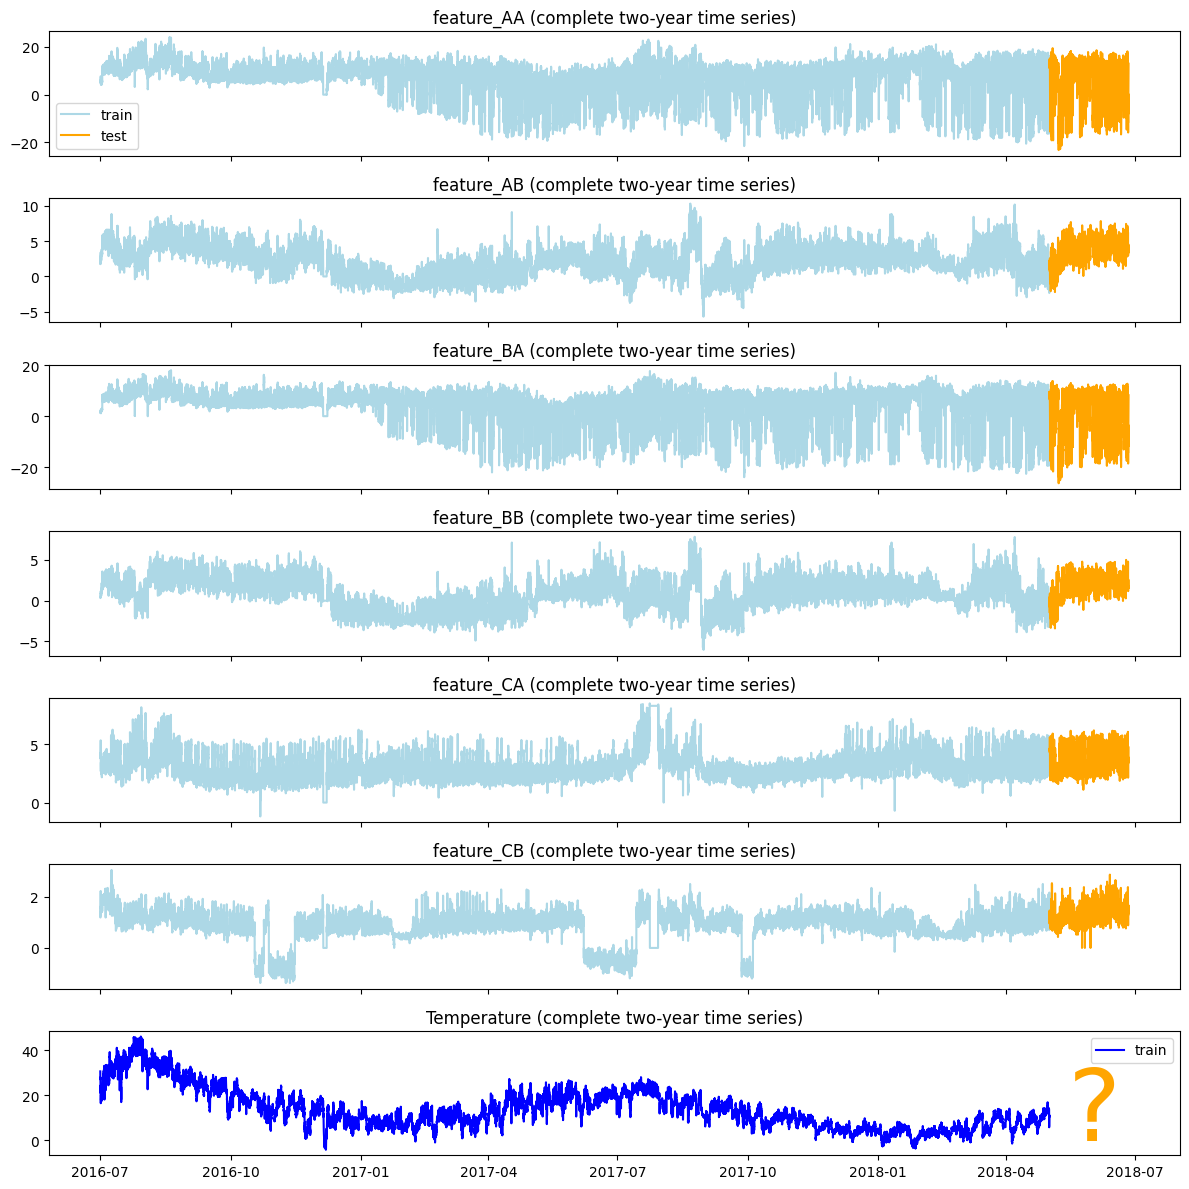

In [5]:
_, axs = plt.subplots(7, 1, sharex=True, figsize=(12, 12))
for ax, col in zip(axs, exogenous_features + ['Temperature']):
    ax.set_title(f"{col} (complete two-year time series)")
    ax.plot(train.date, train[col], label='train', color='lightblue' if col != 'Temperature' else 'b')
    if col != 'Temperature':
        ax.plot(test.date, test[col], label='test', color='orange')
    else:
        ax.text(pd.to_datetime('2018-05-15'), 0, '?', fontsize=72, color='orange')
    if col in ['feature_AA', 'Temperature']:
        ax.legend()
plt.tight_layout()
plt.show()

Let's zoom into the first week of the time series. What can we see?
- Some correlation among the features is still visible.
- feature_CA exhibits a daily pattern.

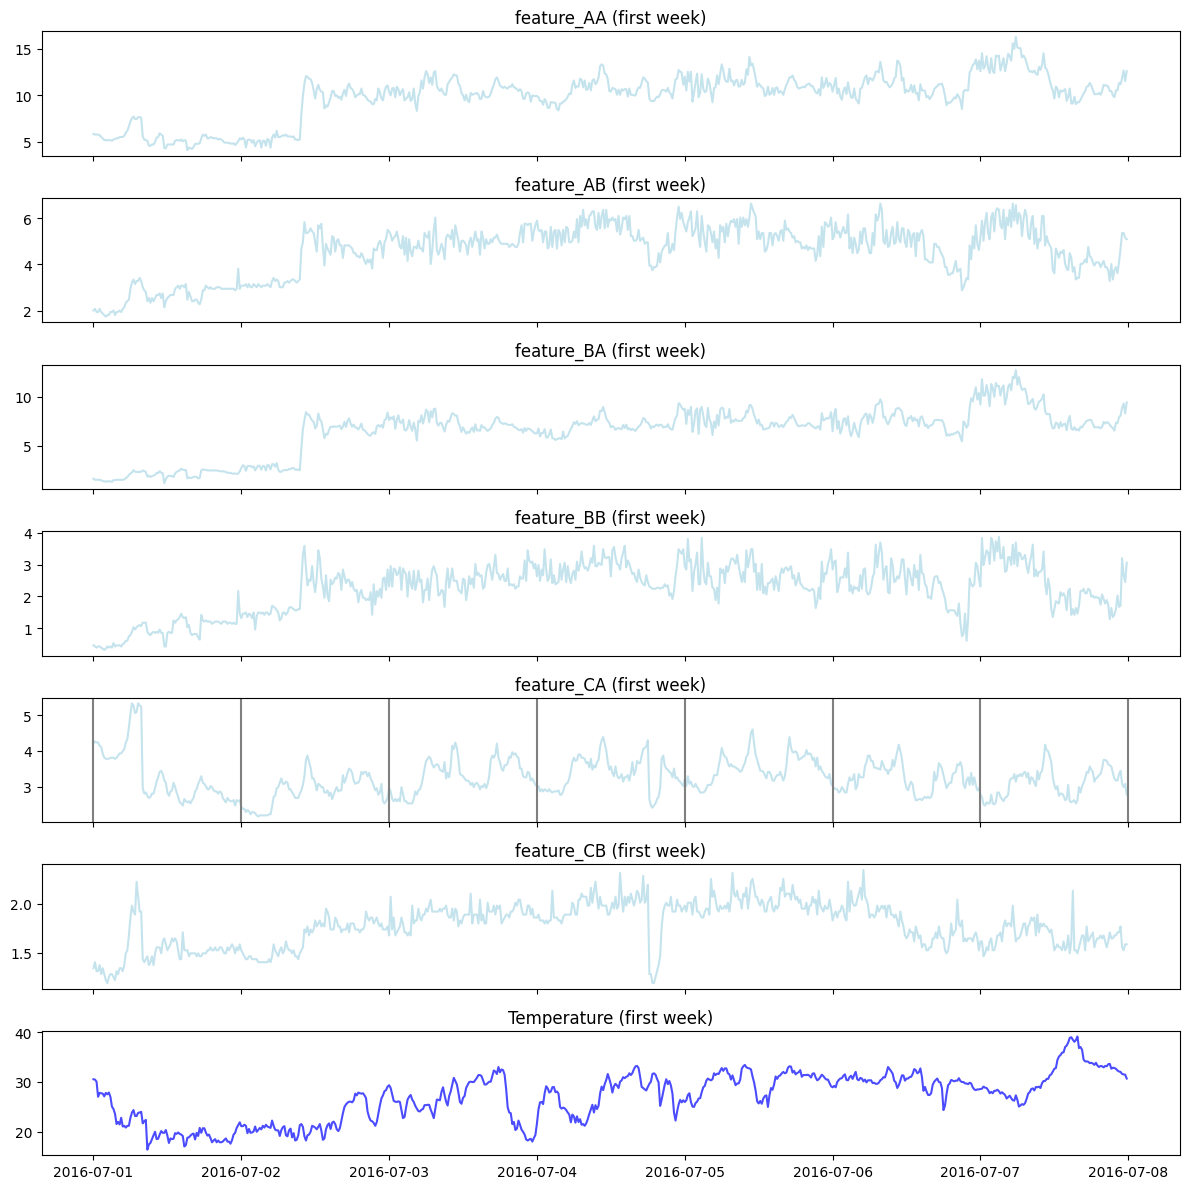

In [6]:
temp = train.iloc[:7*24*4]
_, axs = plt.subplots(7, 1, sharex=True, figsize=(12, 12))
for ax, col in zip(axs, exogenous_features + ['Temperature']):
    ax.set_title(f"{col} (first week)")
    ax.plot(temp.date, temp[col], label='train', alpha=0.7, 
            color='lightblue' if col != 'Temperature' else 'b')
    if col == 'feature_CA':
        for x in pd.date_range(start=train.iloc[0].date, periods=8, freq='d'):
            ax.axvline(x, color='gray')
plt.tight_layout()
plt.show()

# Feature correlation

The correlation matrix confirms the correlations seen above, but I don't know yet what to make of this information. It's just another useless heatmap...

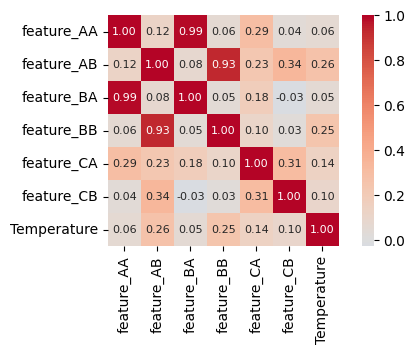

In [7]:
plt.figure(figsize=(6, 3))
corr = np.corrcoef(train[exogenous_features + ['Temperature']], rowvar=False)
sns.heatmap(corr, cmap='coolwarm', center=0,
            xticklabels=exogenous_features + ['Temperature'],
            yticklabels=exogenous_features + ['Temperature'],
            annot=True, fmt='.2f', annot_kws={'fontsize': 8})
plt.gca().set_aspect('equal')
plt.show()

# Periodograms

A periodogram serves to identify the important frequencies in a time series.

The [periodograms](https://en.wikipedia.org/wiki/Periodogram) of all features show a strong peak at a frequency of 365/year (i.e., a period of one day) (and multiples of this frequency). The temperature periodogram additionally shows a strong peak at 1/year (i.e., a period of one year).

Insight: For some models, we need to add features which account for the daily and yearly periodicity of the target.

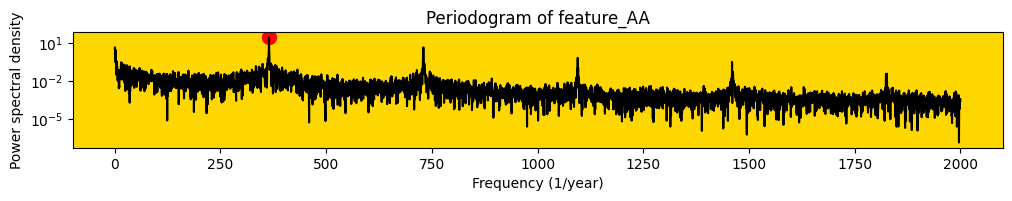

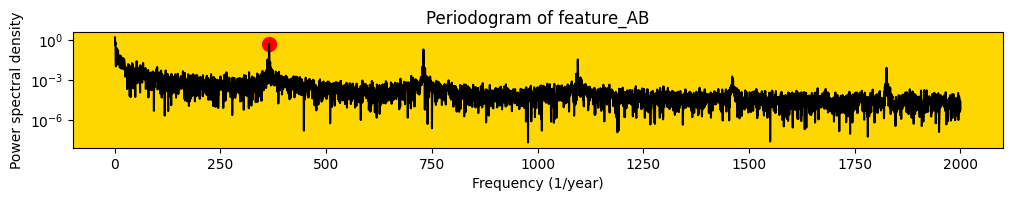

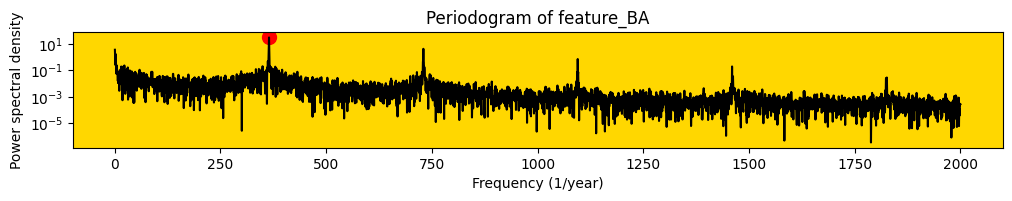

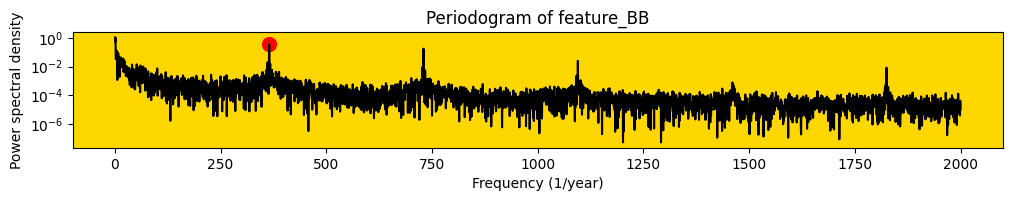

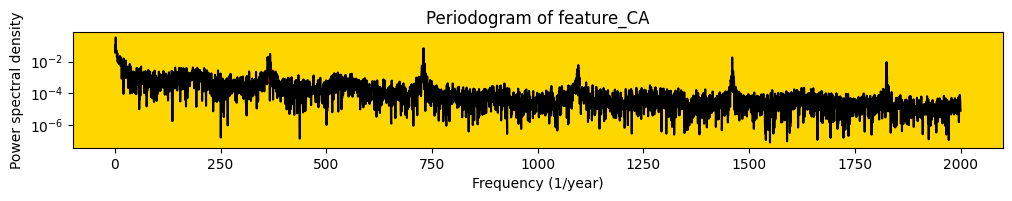

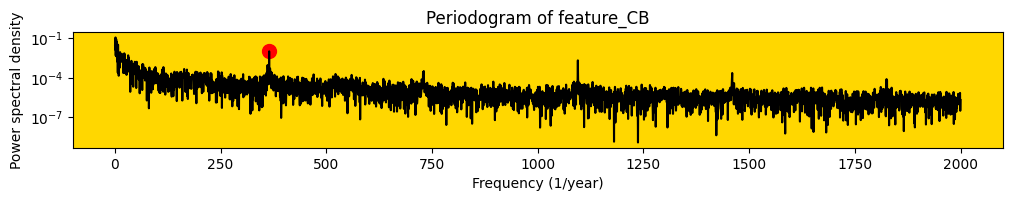

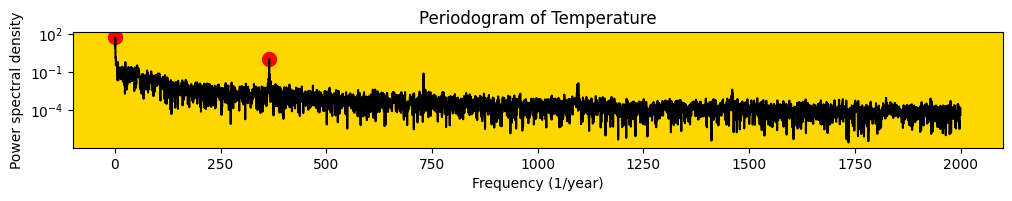

In [8]:
# Plot daily averages and periodograms
for f in exogenous_features + ['Temperature']:
    ff, Pxx = scipy.signal.periodogram(train[f], 4*24 * 365, detrend='linear')
    # ff = frequency in 1/year
    plt.figure( figsize=(12, 1.5))
    ax = plt.gca()
    ax.set_facecolor('#ffd700') # yellow
    f_max = 2000
    ax.semilogy(ff[ff <= f_max][1:], Pxx[ff <= f_max][1:], color='k')
    index = np.argmax(ff >= 365)
    ax.scatter([365], Pxx[index], color='r', s=100)
    if f == 'Temperature':
        index = np.argmax(ff >= 1)
        ax.scatter([1], Pxx[index], color='r', s=100)
    ax.set_xlabel('Frequency (1/year)')
    ax.set_ylabel('Power spectral density')
    ax.set_title(f'Periodogram of {f}', color='k')

    plt.show()


# The daily pattern

The periodogram suggests that there is a daily recurring pattern. We make the pattern visible by plotting the average temperature for every time of day and see that afternoons are two degrees warmer than mornings.

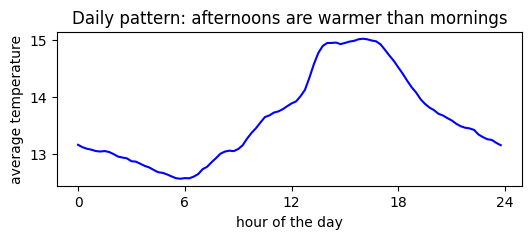

In [9]:
temp = train.Temperature.groupby((train.date - train.date.dt.normalize()).dt.seconds / 3600).mean()
plt.figure(figsize=(6, 2))
plt.plot(temp.index, temp, color='b')
plt.xticks([0, 6, 12, 18, 24])
plt.title('Daily pattern: afternoons are warmer than mornings')
plt.xlabel('hour of the day')
plt.ylabel('average temperature')
plt.show()

# The 31st of every month is a special day

@paddykb has discovered that [observations are constant on the 31st](https://www.kaggle.com/competitions/probabilistic-forecasting-i-temperature/discussion/492913) of every month. The observation applies to training and test data.

Perhaps the data has been generated for 30-day months, and the 31st of every month was forward-filled. 

**Insight:**
1. Consider dropping the 31st of every month before training.
2. Apply some special method when forecasting May 31, 2018.

In [10]:
print((~ (train.date.dt.day == 31)
       | (train[exogenous_features + ['Temperature']] == train[exogenous_features + ['Temperature']].shift()).all(axis=1)).all())
print((~ (test.date.dt.day == 31)
       | (test[exogenous_features] == test[exogenous_features].shift()).all(axis=1)).all())

True
True


# Missing values around December 6, 2016

Around the 6th of December, 2016, there are 234 rows where all six features are zero while the temperature fluctuates. Fortunately the test dataset has no missing values.

**Insight:** These zeros can be considered as missing values. We can try to impute values for the features or (much simpler) drop the affected rows.

In [11]:
display(train[(train[exogenous_features] == 0).all(axis=1)])

display(test[(test[exogenous_features] == 0).all(axis=1)])

,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
id,,,,,,,,
15106,2016-12-05 08:30:00,0.0,0.0,0.0,0.0,0.0,0.0,16.954
15107,2016-12-05 08:45:00,0.0,0.0,0.0,0.0,0.0,0.0,15.898
15108,2016-12-05 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,15.336
15109,2016-12-05 09:15:00,0.0,0.0,0.0,0.0,0.0,0.0,14.914
15110,2016-12-05 09:30:00,0.0,0.0,0.0,0.0,0.0,0.0,14.210
...,...,...,...,...,...,...,...,...
15335,2016-12-07 17:45:00,0.0,0.0,0.0,0.0,0.0,0.0,1.337
15336,2016-12-07 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.266
15337,2016-12-07 18:15:00,0.0,0.0,0.0,0.0,0.0,0.0,1.196


,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB
id,,,,,,,


# Stuck sensors

The training dataset contains a few periods where all sensors including the temperature sensor are stuck to some value. The longest such period occurs on the 9th of January, 2017. The test dataset has no stuck sensors.

**Insight:** We can declare these measurements to be erroneous and delete them from the dataset.

In [12]:
# Find stuck sensors in training data
stuck_mask = (train[exogenous_features + ['Temperature']] == train[exogenous_features + ['Temperature']].shift()).all(axis=1)
stuck_mask &= train.date.dt.day != 31
stuck_mask &= ~ (train[exogenous_features] == 0).all(axis=1)
with pd.option_context("display.max_rows", 1000):
    display(train[stuck_mask])
    
# Find stuck sensors in test data
stuck_mask = (test[exogenous_features] == test[exogenous_features].shift()).all(axis=1)
stuck_mask &= test.date.dt.day != 31
stuck_mask &= ~ (test[exogenous_features] == 0).all(axis=1)
with pd.option_context("display.max_rows", 1000):
    display(test[stuck_mask])

,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
id,,,,,,,,
8206,2016-09-24 11:30:00,7.502,3.818,4.868,1.883,2.619,0.944,24.410000
10345,2016-10-16 18:15:00,6.430,1.942,4.406,1.031,2.071,0.670,21.385000
10531,2016-10-18 16:45:00,7.100,0.000,5.117,0.711,1.858,-0.914,20.823000
10537,2016-10-18 18:15:00,6.765,0.134,4.584,0.888,2.102,-0.975,20.190001
10540,2016-10-18 19:00:00,6.296,0.067,4.442,0.853,2.071,-1.005,19.908001
10635,2016-10-19 18:45:00,6.497,-0.067,4.513,0.782,2.132,-1.066,19.979000
15373,2016-12-08 03:15:00,3.885,1.206,0.000,0.000,3.838,1.249,10.552000
16098,2016-12-15 16:30:00,9.846,-0.067,6.361,-1.883,2.711,1.218,10.693000
16099,2016-12-15 16:45:00,9.846,-0.067,6.361,-1.883,2.711,1.218,10.693000


,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB
id,,,,,,,


# Feature engineering

In time series prediction, we first of all have to get the trend and the seasonalities right. For this purpose, we add five features to the dataset.

In [13]:
for df in [train, test]:
    df['trend'] = (df.date - train.date.iloc[0]).dt.total_seconds() / 60 / 15
    df['day_cos'] = np.cos(df.trend / 96 * 2 * math.pi)
    df['day_sin'] = np.sin(df.trend / 96 * 2 * math.pi)
    df['year_cos'] = np.cos(df.trend / 96 / 365 * 2 * math.pi)
    df['year_sin'] = np.sin(df.trend / 96 / 365 * 2 * math.pi)

all_features = list(test.columns[1:]) # without date

# Point predictions

As a warmup, let's try our luck with simple point predictions using `LinearRegression` and `HistGradientBoostingRegressor`. We use five four-week periods of the second year for validation. The first year of the dataset is used only for training. You should see the five validation periods in the diagrams.

Interestingly enough, linear regression is better than the gradient-boosted trees. Maybe I need to better tune the hyperparameters, or **trees simply aren't good at extrapolating trends** 😉.

LinearRegression
Fold  6: RMSE=2.84 MAE=2.30
Fold  7: RMSE=5.58 MAE=4.86
Fold  8: RMSE=3.80 MAE=3.29
Fold  9: RMSE=3.79 MAE=3.19
Fold 10: RMSE=3.44 MAE=2.86
Overall  RMSE=4.00 MAE=3.30


/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To cal

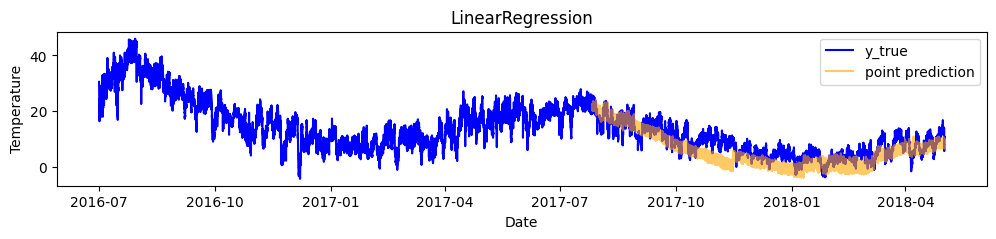

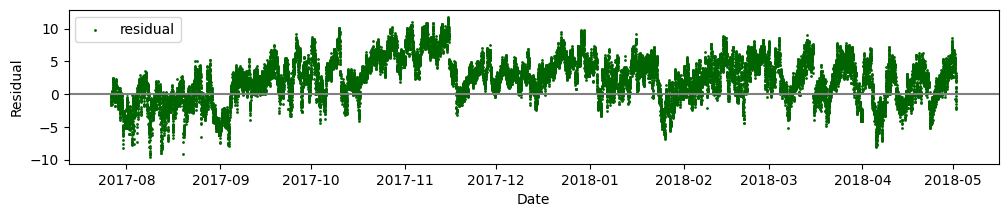

HistGradientBoostingRegressor


/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold  6: RMSE=6.41 MAE=5.74


/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold  7: RMSE=3.87 MAE=3.12


/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold  8: RMSE=5.49 MAE=4.94


/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold  9: RMSE=2.35 MAE=1.88
Fold 10: RMSE=4.68 MAE=3.72
Overall  RMSE=4.77 MAE=3.88


/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


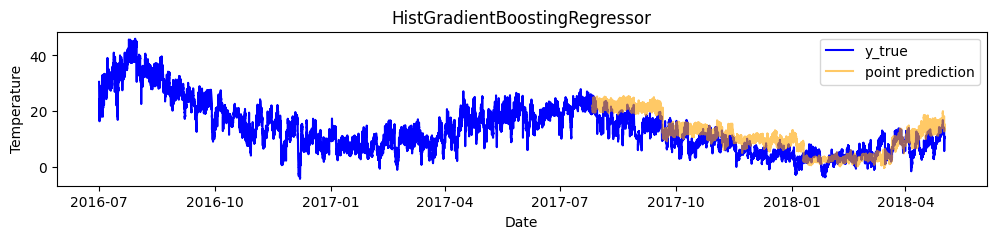

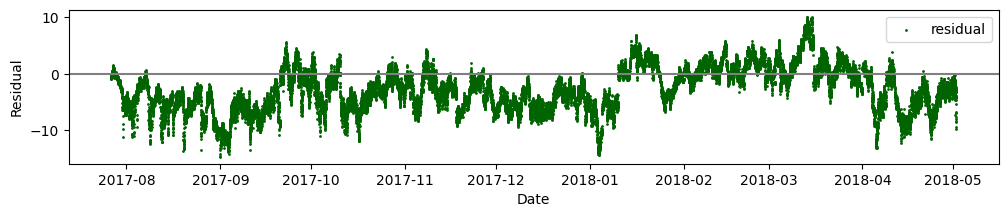

In [14]:
def cross_validate_point_prediction(model, label=None):
    """Cross-validate a point-prediction regression model.
    
    Cross-validates the model with five time-series splits, then outputs
    RMSE, MAE and two diagrams.
    """
    if label is None:
        label = type(model).__name__
    print(label)
    tss = TimeSeriesSplit(n_splits=11)
    dates, oof, y_true = [], [], []
    for fold, (idx_tr, idx_va) in enumerate(tss.split(train)):
        if fold <= 5: continue
        X_tr = train.iloc[idx_tr][all_features + ['Temperature']]
        X_va = train.iloc[idx_va][all_features + ['Temperature']]
        y_tr = X_tr.pop('Temperature')
        y_va = X_va.pop('Temperature')

        model.fit(X_tr, y_tr)
        y_va_pred = model.predict(X_va)
        rmse = mean_squared_error(y_va, y_va_pred, squared=False)
        mae = mean_absolute_error(y_va, y_va_pred)
        print(f"Fold {fold:2}: RMSE={rmse:.2f} MAE={mae:.2f}")
        dates.append(train.iloc[idx_va].date)
        oof.append(pd.Series(y_va_pred, index=y_va.index, name='y_pred'))
        y_true.append(y_va)

    dates = pd.concat(dates)
    oof = pd.concat(oof)
    y_true = pd.concat(y_true)
    rmse = mean_squared_error(y_true, oof, squared=False)
    mae = mean_absolute_error(y_true, oof)
    print(f"{Fore.GREEN}Overall  RMSE={rmse:.2f} MAE={mae:.2f}{Style.RESET_ALL}")

    plt.figure(figsize=(12, 2))
    plt.title(label)
    plt.ylabel('Temperature')
    plt.xlabel('Date')
    plt.plot(train.date, train.Temperature, label='y_true', color='b')
    plt.plot(dates, oof, label='point prediction', alpha=0.6, color='orange')
    plt.legend()
    plt.show()

    residuals = y_true - oof
    plt.figure(figsize=(12, 2))
    plt.ylabel('Residual')
    plt.xlabel('Date')
    plt.scatter(dates, residuals, color='darkgreen', s=1, label='residual')
    plt.axhline(0, color='gray')
    plt.legend()
    plt.show()
    
model = LinearRegression()
cross_validate_point_prediction(model)

hgb_params = {'max_iter': 100, 'early_stopping': False, 'learning_rate': 0.16, 'max_leaf_nodes': 53, 'min_samples_leaf': 6}
model = HistGradientBoostingRegressor(**hgb_params)
cross_validate_point_prediction(model)


# Probabilistic forecasting

Now we're ready for probabilistic forecasts. Our model splits the data into training and calibration datasets. A linear regressor is trained on the training data so that point predictions and residuals for the calibration dataset can be computed. We then determine the quantiles of these residuals, assuming that the noise is homoscedastic.

For cross-validation, we make four folds. Every fold uses four weeks for validation, the four weeks before that for calibration, and all earlier data for training.

Linear regression again wins against gradient-boosting.


HistGradientBoostingRegressor


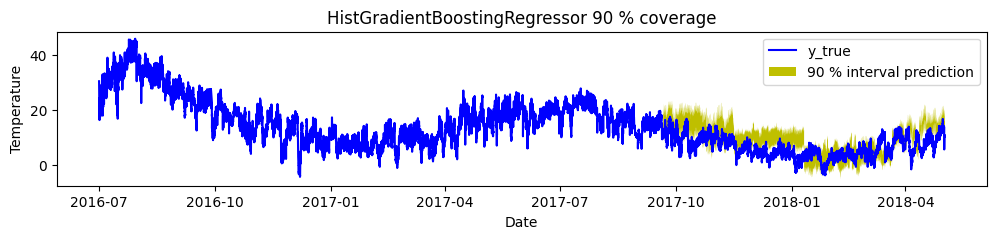

In [17]:
feature_subset = ['trend', 'day_cos', 'day_sin', 'year_cos', 'year_sin', 'date']

def fit_predict_all_quantiles(model, date_tr, X_tr, y_tr, X_te):
    """Fit, calibrate and predict
    
    Splits date_tr, X_tr, y_tr into training and calibration set, fits the model
    for point predictions to the training set, calibrates all quantiles to the 
    calibration set and then predicts all quantiles for X_te
    
    Parameters
    model: a point-prediction regression model
    date_tr: 1d array of shape (n_samples, ) of datetimes
    X_tr: 2d array of shape (n_samples, n_features)
    y_tr: 1d array of shape (n_samples, )
    X_te: 2d array of shape (n_samples_test, n_features)
    
    Return value
    predictions_df: dataframe of shape (n_samples_test, 21)
    """
    # Split into training and calibration
    split_date = date_tr.max() - pd.to_timedelta(28, unit='D') # use 28 days for calibration
    mask_tr = date_tr <= split_date
    X_tr, X_ca = X_tr[mask_tr], X_tr[~mask_tr]
    y_tr, y_ca = y_tr[mask_tr], y_tr[~mask_tr]
#         print(f'Train {len(X_tr)} calibrate {len(X_ca)} predict {len(X_te)}')

    # Fit, predict for calibration, compute residuals 
    model.fit(X_tr, y_tr)
    y_ca_pred = model.predict(X_ca)
    residuals = y_ca - y_ca_pred

    # Determine the quantiles of the residuals
    qs = [0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30,
                 0.35,  0.40, 0.45, 0.50, 0.55, 0.60, 0.65,
                 0.70,  0.75, 0.80, 0.85, 0.90, 0.95, 0.975]
    quantiles = [(q, np.quantile(residuals, q)) for q in qs]

    y_va_pred = model.predict(X_te)
    predictions_df = pd.DataFrame({q: y_va_pred + quantile for (q, quantile) in quantiles})
    return predictions_df

def cross_validate_probabilistic(model, label=None):
    """Cross-validate a model
    
    Cross-validates the model with four time-series splits and outputs
    the continuous ranked probability scores (CRPS) and a diagram.
    """
    if label is None:
        label = type(model).__name__
    print()
    print(label)
    tss = TimeSeriesSplit(n_splits=11)
    dates, oof, y_true = [], [], []
    for fold, (idx_tr, idx_va) in enumerate(tss.split(train)):
        if fold <= 6: continue
        X_tr = train.iloc[idx_tr].copy()[feature_subset + ['Temperature']]
        X_va = train.iloc[idx_va].copy()[feature_subset + ['Temperature']]
        date_tr = X_tr.pop('date')
        date_va = X_va.pop('date')
        y_tr = X_tr.pop('Temperature')
        y_va = X_va.pop('Temperature')

        predictions_df = fit_predict_all_quantiles(model, date_tr, X_tr, y_tr, X_va)
        dates.append(date_va)
        oof.append(predictions_df)
        y_true.append(y_va)

    dates = pd.concat(dates)
    oof = pd.concat(oof, axis=0)
    y_true = pd.concat(y_true)

    plt.figure(figsize=(12, 2))
    plt.title(f"{label} 90 % coverage")
    plt.ylabel('Temperature')
    plt.xlabel('Date')
    plt.plot(train.date, train.Temperature, label='y_true', color='b')
    plt.fill_between(dates, oof[0.05], oof[0.95],
                     color='y', linewidth=0,
                     label='90 % interval prediction')
    plt.legend()
    plt.show()

model = LinearRegression()

hgb_params = {'max_iter': 100, 'early_stopping': False, 'learning_rate': 0.16, 'max_leaf_nodes': 53, 'min_samples_leaf': 6}
model = HistGradientBoostingRegressor(**hgb_params)
cross_validate_probabilistic(model)


# Submission

We refit the linear regression model to the whole training data and create a submission file. The diagram serves to plausibilize the predictions.

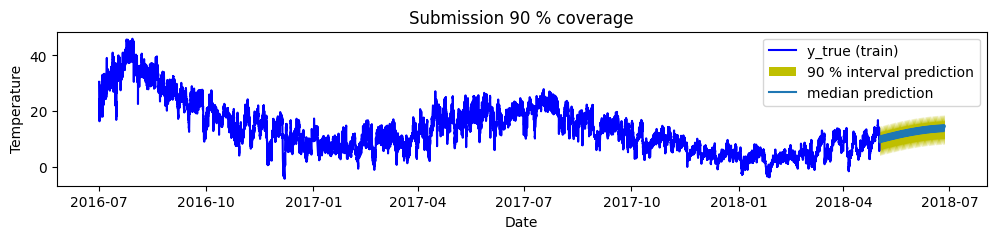

,0.025,0.050,0.100,0.150,0.200,0.250,0.300,0.350,0.400,0.450,0.500,0.550,0.600,0.650,0.700,0.750,0.800,0.850,0.900,0.950,0.975
id,,,,,,,,,,,,,,,,,,,,,
64320,3.3,4.6,5.8,6.5,7.1,7.4,7.7,8.0,8.5,9.0,9.4,9.8,10.2,10.5,10.8,11.3,11.6,12.0,12.5,13.1,13.5
64321,3.2,4.6,5.7,6.4,7.0,7.3,7.6,8.0,8.5,9.0,9.3,9.8,10.1,10.4,10.8,11.2,11.5,11.9,12.4,13.0,13.4
64322,3.2,4.5,5.7,6.4,7.0,7.3,7.5,7.9,8.4,8.9,9.3,9.7,10.1,10.4,10.7,11.2,11.5,11.9,12.3,13.0,13.4
64323,3.1,4.5,5.6,6.3,6.9,7.2,7.5,7.9,8.4,8.9,9.2,9.7,10.0,10.3,10.6,11.1,11.4,11.8,12.3,12.9,13.3
64324,3.1,4.4,5.6,6.3,6.9,7.2,7.4,7.8,8.3,8.8,9.1,9.6,10.0,10.3,10.6,11.1,11.4,11.8,12.2,12.9,13.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69675,8.7,10.0,11.1,11.9,12.5,12.8,13.0,13.4,13.9,14.4,14.7,15.2,15.5,15.9,16.2,16.6,17.0,17.3,17.8,18.5,18.9
69676,8.6,10.0,11.1,11.8,12.4,12.7,13.0,13.3,13.8,14.3,14.7,15.1,15.5,15.8,16.1,16.6,16.9,17.3,17.8,18.4,18.8
69677,8.6,9.9,11.0,11.8,12.4,12.7,12.9,13.3,13.8,14.3,14.6,15.1,15.4,15.8,16.1,16.5,16.9,17.3,17.7,18.4,18.8


In [18]:
X_tr = train.copy()[feature_subset + ['Temperature']]
X_te = test.copy()[feature_subset]
date_tr = X_tr.pop('date')
date_te = X_te.pop('date')
y_tr = X_tr.pop('Temperature')

model = LinearRegression()
submission = fit_predict_all_quantiles(model, date_tr, X_tr, y_tr, X_te)
submission.index = test.index
submission.to_csv('submission.csv')

plt.figure(figsize=(12, 2))
plt.title(f"Submission 90 % coverage")
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.plot(train.date, train.Temperature, label='y_true (train)', color='b')
plt.fill_between(date_te, submission[0.05], submission[0.95],
                 color='y', linewidth=0,
                 label='90 % interval prediction')
plt.plot(date_te, submission[0.5], label='median prediction')
plt.legend()
plt.show()

with pd.option_context("display.max_columns", 21):
    display(submission.round(1))
